In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits
from scipy.signal import savgol_filter

%matplotlib notebook

# Import fits

In [2]:
def importFits(file_path):
    """Import a FITs file. Can process a 2-D single 
    image data array or a 3-D image datacube.  Return is a single Image
    object or a list of Image objects."""

    ## Read fits file
    hdulist = fits.open(file_path, memmap=True)
    data = hdulist[0].data

    shape = data.shape

    ## Create Image objects
    if len(shape) == 2:
        return data
    elif len(shape) == 3:
        image_list = []
        
    ## Iterate over datacube and initialize Image objects
        for i in range(data.shape[0]):
            single_image_data = data[i,:,:]
            image_list.append(single_image_data)  
        return image_list
    else:
        print(shape)
        sys.exit("FITs Read Error: Must be 2-D or 3-D Image datacube")

In [3]:
file_name = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_5.53.56_poldm_phase.fits"

In [183]:
phase_list = importFits(file_name)[0:-1:5000]
single_phase = phase_list[0]

In [184]:
len(phase_list)

5

In [174]:
def PSD(phase,aperature):
    ## Take the fourier transform of the image.
    F1 = fft.fft2(pupil_phase)

    ## Shift quadrants around so that low spatial frequencies are in
    ## the center of the 2D fourier transformed image.
    F2 = fft.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the radially averaged 1D power spectrum
    psd1D = radialProfile(psd2D)
    return psd1D

In [185]:
psd_list = [PSD(i,aperature) for i in phase_list]

In [186]:
psd_avg = np.mean(psd_list,axis=0)

# Plot functions

In [6]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar."""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

In [117]:
def PSDplot(psd, display=True, **kwargs):
    """Plot the 1D psd"""
    
    ##  create matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ## Perform linear fit to smoothed PSD
    f = np.arange(psd.shape[0])
    par = np.polyfit(np.log10(f[f>1.]), np.log10(psd[f>1.]), deg = 1)
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog(f[1:], psd[1:],'b',(10**intercept)*f[f>1.]**slope, 'r',)
    
    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)], loc=3, fontsize=18)
    
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.set_ylabel('Power Spectrum', fontsize=24)
    ax.set_xlabel('Spatial Frequency', fontsize=24)
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if display: plt.show()

<IPython.core.display.Javascript object>


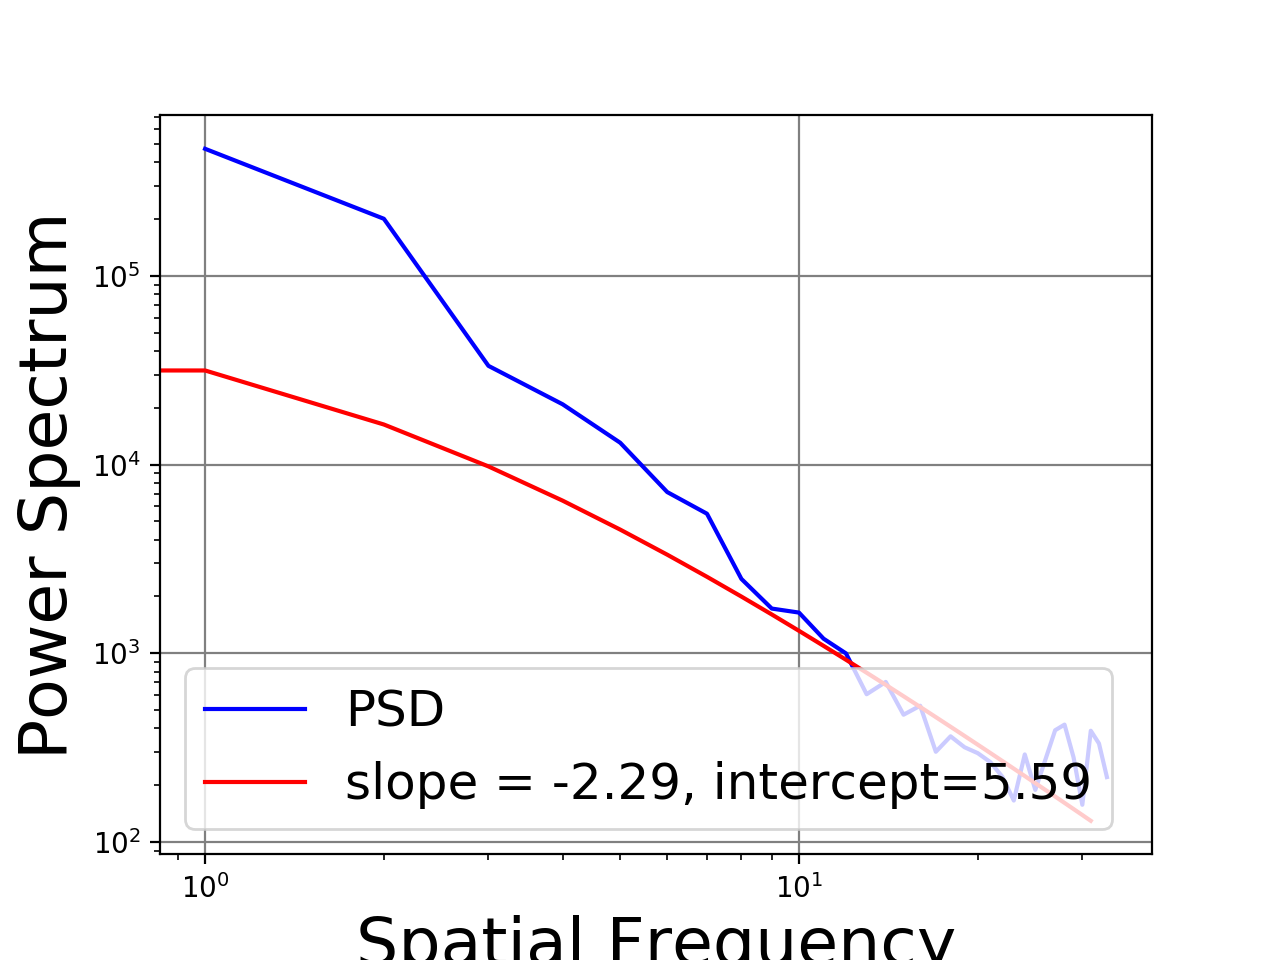

In [118]:
PSDplot(psd1D)

# Get pupil

In [11]:
def getPupil(image, pixscale=7.77/43, whole=False, freqshift=False):
    """Create an array mask representing the telescope pupil
    for a given image size and pixel scale.
    """

    ## Initial variables for pupil size and scale
    n = image.shape[0]
    outD = 7.7
    inD = 1.024

    xgrid = np.zeros((n,n))

    ## Check if frequency scale flag is set
    if freqshift:
        for j in np.arange(n):
            xgrid[:,j] = j - (j > n/2)*n
    else:
        for j in np.arange(n):
            xgrid[:,j] = j
        if (n % 2):
            if whole:
                offset = (n-1)/2.0
            else:
                offset = 0.
        else:
            if whole:
                offset = n/2.0
            else:
                offset = (n-1)/2.0
        xgrid = xgrid - offset
    
    ## Construct grid of radial distances from center
    ax = xgrid * pixscale
    ay = ax.transpose()
    ar = np.sqrt(ax**2 + ay**2)

    ## Construct boolean array to characterize pupil
    ap_outer = (ar < outD/2)
    ap_inner = (ar < inD/2)        
    pupil = ap_outer ^ ap_inner

    ## Return boolean array for use as array mask
    return pupil

In [13]:
aperature = getPupil(single_phase)
pupil_phase =  aperature * single_phase 

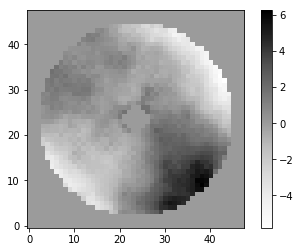

In [14]:
implot(pupil_phase)

# Radial profile 

In [173]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    ## how many per bin (i.e., histogram)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())

    ## average in each bin
    radialprofile = tbin / nr
    
    return radialprofile 


# Fourier transform of image 

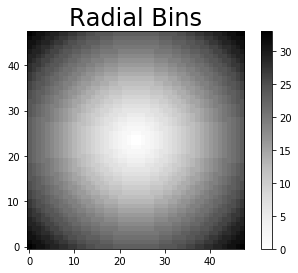

In [20]:
## Take the fourier transform of the image.
F1 = fft.fft2(pupil_phase)

## Shift quadrants around so that low spatial frequencies are in
## the center of the 2D fourier transformed image.
F2 = fft.fftshift( F1 )

# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2

# Calculate the radially averaged 1D power spectrum
psd1D = radialProfile(psd2D)

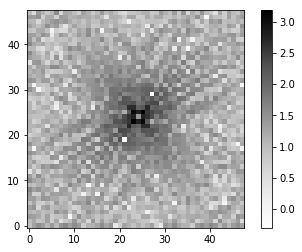

In [18]:
implot(np.log10(F2).real)